## **Implementación en PyTorch**

###**Importación de Librerias**
Se utilizaron librerias como `numpy` para las operaciones numéricas y `matplotlib` para las visualizaciones, `torch`, `torchvision` (para los conjuntos de datos y las transformaciones) y `torch.nn` para construir y entrenar el modelo

Este modelo se entrenó utilizando una GPU en Google Colab por lo que también
importaron las librerias necesarias junto con la definición de una variable device, para que la máquina sepa que debe usar una GPU para entrenar el modelo si está disponible.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Carga y Preprocesamiento de los datos CIFAR-10**

Si bien AlexNet se entrenó originalmente con el enorme conjunto de datos ImageNet (con más de 14 millones de imágenes etiquetadas), por esta razón, en este trabajo utilizamos el conjunto de datos CIFAR-10, que es más pequeño pero sigue siendo lo suficientemente diverso para experimentar con modelos de aprendizaje profundo.

AlexNet espera que los datos de entrada tengan un tamaño de 227 × 227. Sin embargo, los conjuntos de datos como CIFAR-10 incluyen imágenes de 32 × 32. Esto significa que se cambió el tamaño de las imágenes durante el preprocesamiento. Además de cambiar el tamaño, también se normalizaron para garantizar que los valores de los píxeles se encuentren dentro de un rango que acelere la convergencia durante el entrenamiento.

100%|██████████| 170M/170M [00:04<00:00, 42.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


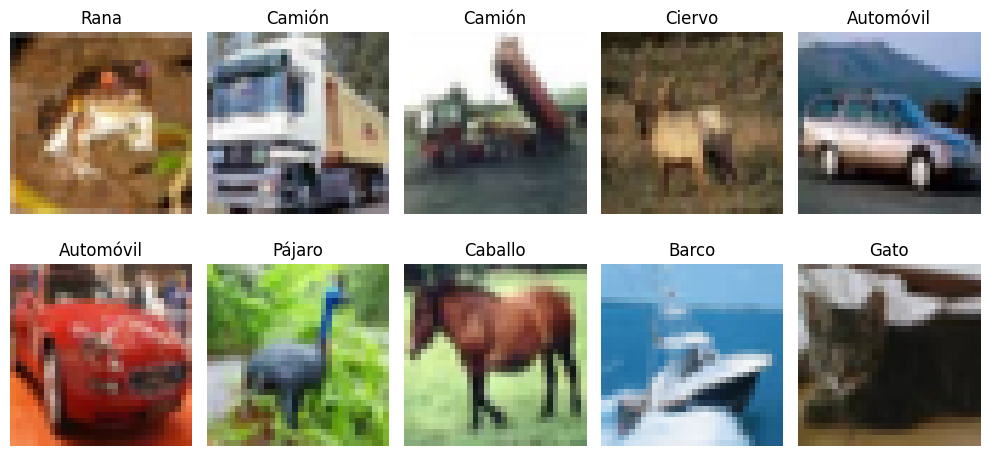

In [ ]:
# Definir la transformación para normalizar y convertir en tensor
transform = transforms.Compose([transforms.ToTensor()])

# Descargar y cargar el conjunto de datos CIFAR-10
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Clases de CIFAR-10
classes = ['Avión', 'Automóvil', 'Pájaro', 'Gato', 'Ciervo', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']

# Preprocesamiento con redimensionamiento a 224x224
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # AlexNet espera imágenes de 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[ 0.485 , 0.456 , 0.406 ], std=[ 0.229 , 0.224 , 0.225 ])  # Normalizar
])

# Cargar los datos
batch_size = 64
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Seleccionar algunas imágenes aleatorias
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    img, label = cifar10_train[i]  # Obtener imagen y etiqueta
    img = np.transpose(img.numpy(), (1, 2, 0))  # Reordenar dimensiones para visualizar
    ax.imshow(img)
    ax.set_title(classes[label])
    ax.axis('off')

plt.tight_layout()
plt.show()


####**Explicación de las transformaciones**

**Cambiar tamaño** : AlexNet fue diseñado para imágenes de alta resolución, ya que su objetivo era extraer características espaciales de fine-grained. AlexNet espera entradas de 224×224, por lo que redimensionamos las imágenes.

**ToTensor** : convierte la imagen de un formato PIL a un tensor PyTorch. Este paso es crucial porque los modelos PyTorch no funcionan con formatos de imagen sin procesar.

**Normalización** : La media [0,485, 0,456, 0,406] y la desviación estándar [0,229, 0,224, 0,225] se basan en las estadísticas de ImageNet. Si bien CIFAR-10 no es ImageNet, el uso de estos valores es una convención práctica para los modelos entrenados previamente o al replicar arquitecturas como AlexNet. La normalización ayuda a estandarizar el conjunto de datos, lo que garantiza una convergencia más rápida y una mejor estabilidad numérica.



### **Definición del modelo AlexNet**

Se definió la clase AlexNet con las capas convolucionales, de pooling y densas, siguiendo la arquitectura original

In [ ]:
# Definir la arquitectura AlexNet personalizada
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2), # Conv1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # MaxPool1

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), # Conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # MaxPool2

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), # Conv3
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),  # Conv4
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),  # Conv5
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2) # MaxPool3
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096), #FC1
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(4096, 4096), # FC2
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes) # FC3
        )

    def forward(self, x):
        x = self.features(x)   # Pasar a través de capas convolucionales
        x = torch.flatten(x, 1 )   # Aplanar la salida para las capas completamente conectadas
        x = self.classifier(x)   # Pasar a través del clasificador
        return x


##### **1. Extractor de Características (Capas Convolucionales y Max Pooling)**  

- **Conv1:** Aplica 64 filtros de tamaño **11 × 11** con un stride de 4, lo que reduce significativamente la dimensión espacial.  
- **ReLU:** Introduce no linealidad, permitiendo que la red capture patrones complejos.  
- **MaxPool:** Reduce el tamaño espacial mientras conserva las características más importantes.  
- **Conv2-Conv5:** Refinan la extracción de características con filtros más pequeños, aprendiendo representaciones progresivamente más abstractas.  

##### **2. Clasificador (Capas Densas y Dropout)**  

- **FC1 y FC2:** Expanden la representación de las características a un espacio de **4096 dimensiones**, permitiendo que el modelo aprenda combinaciones complejas de características.  
- **Dropout:** Apagado aleatorio de neuronas para reducir el sobreajuste.  
- **FC3:** Asigna la representación final a las **10 clases** de CIFAR-10.

### **Configuración de Hiperparámetros**
Antes del entrenamiento, necesitamos establecer algunos hiperparámetros, como la función de pérdida y el optimizador que se utilizará junto con el tamaño del lote, la tasa de aprendizaje y la cantidad de épocas.


In [ ]:
# Hiperparámetros
batch_size = 64
epochs = 20
learning_rate = 0.005

custom_model = AlexNet().to(device)  # Modelo personalizado

# Función de pérdida y optimizadores
criterion = nn.CrossEntropyLoss()
custom_optimizer = optim.SGD(custom_model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  # Optimizador para modelo desde cero


**Función de pérdida** : estoy usando CrossEntropyLoss, que es perfecta para problemas de clasificación de múltiples clases como CIFAR-10.

**Optimizador** : el descenso de gradiente estocástico (SGD) con caída de peso y momentum es una opción recomendada para entrenar AlexNet. El momentum ayuda a que el modelo escape de los mínimos locales y la caída de peso lo regulariza.

### **Entrenamiento del Modelo**

El modelo se entrenó durante 20 épocas utilizando el optimizador SGD con momentum. La función de pérdida utilizada fue CrossEntropyLoss.

In [ ]:
def evaluate_model(model, print_class_accuracy=True):
    model.eval()
    correct, total, total_loss = 0, 0, 0
    class_correct = np.zeros(10)
    class_total = np.zeros(10)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()

            for i in range(len(labels)):
                label = labels[i].item()
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    val_accuracy = 100 * correct / total
    avg_val_loss = total_loss / len(test_loader)

    if print_class_accuracy:
        print("\n--- Accuracy por Clase ---")
        for i in range(10):
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f"{classes[i]}: {accuracy:.2f}%")
        print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

    return val_accuracy, avg_val_loss


In [ ]:
# Funciones de entrenamiento y evaluación
def train_model(model, optimizer, model_name):
    model.train()
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        val_accuracy, val_loss = evaluate_model(model, False)  # Evaluar en test set sin imprimir

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(train_accuracy)
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)

        print(f"{model_name} - Epoch [{epoch+1}/{epochs}] - "
              f"Loss: {total_loss/len(train_loader):.4f} - "
              f"Accuracy: {train_accuracy:.2f}% - "
              f"Val Loss: {val_loss:.4f} - "
              f"Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

# Entrenar y evaluar ambos modelos
print("Entrenando modelo desde cero...")
custom_train_losses, custom_val_losses, custom_train_accs, custom_val_accs = train_model(custom_model, custom_optimizer, "Custom AlexNet")


Entrenando modelo desde cero...
Custom AlexNet - Epoch [1/20] - Loss: 1.9897 - Accuracy: 25.33% - Val Loss: 1.6652 - Val Accuracy: 38.59%
Custom AlexNet - Epoch [2/20] - Loss: 1.4237 - Accuracy: 48.24% - Val Loss: 1.3645 - Val Accuracy: 52.44%
Custom AlexNet - Epoch [3/20] - Loss: 1.1559 - Accuracy: 58.77% - Val Loss: 1.1058 - Val Accuracy: 61.61%
Custom AlexNet - Epoch [4/20] - Loss: 0.9474 - Accuracy: 67.02% - Val Loss: 0.9060 - Val Accuracy: 68.90%
Custom AlexNet - Epoch [5/20] - Loss: 0.8135 - Accuracy: 71.75% - Val Loss: 0.8127 - Val Accuracy: 72.31%
Custom AlexNet - Epoch [6/20] - Loss: 0.7121 - Accuracy: 75.37% - Val Loss: 0.7511 - Val Accuracy: 74.41%
Custom AlexNet - Epoch [7/20] - Loss: 0.6212 - Accuracy: 78.71% - Val Loss: 0.7300 - Val Accuracy: 74.83%
Custom AlexNet - Epoch [8/20] - Loss: 0.5528 - Accuracy: 81.07% - Val Loss: 0.7529 - Val Accuracy: 75.59%
Custom AlexNet - Epoch [9/20] - Loss: 0.4956 - Accuracy: 83.12% - Val Loss: 0.7099 - Val Accuracy: 76.36%
Custom AlexNet

En este ciclo:

* Comenzamos iterando a través del número de épocas y luego los lotes en nuestros datos de entrenamiento.
* Convertimos las imágenes y las etiquetas según el dispositivo que estemos usando, es decir, GPU o CPU
* En el forward pass, hacemos predicciones utilizando nuestro modelo y calculamos la pérdida en función de esas predicciones y nuestras etiquetas reales.
* A continuación, realizamos el backward pass donde realmente actualizamos nuestros pesos para mejorar nuestro modelo.
* Luego establecemos los gradientes a cero antes de cada actualización usando la función `optimizer.zero_grad()`
* Luego, calculamos los nuevos gradientes utilizando la función loss.backward()
* Y finalmente actualizamos los pesos con la función `optimizer.step()`
* Además, al final de cada época, también utilizamos nuestro conjunto de validación para calcular la precisión del modelo. En este caso, no necesitamos gradientes, por lo que utilizamos `with torch.no_grad()` para una evaluación más rápida.

### **Evaluación del Modelo**

Una vez que el modelo esté entrenado, es momento de evaluar su rendimiento con datos no vistos (`test_loader`).

In [ ]:
# Evaluación final de ambos modelos
print("\nEvaluación final del modelo personalizado:")
evaluate_model(custom_model, print_class_accuracy=True)


Evaluación final del modelo personalizado:

--- Accuracy por Clase ---
Avión: 84.40%
Automóvil: 85.40%
Pájaro: 72.70%
Gato: 65.30%
Ciervo: 80.60%
Perro: 60.50%
Rana: 78.10%
Caballo: 86.10%
Barco: 89.30%
Camión: 88.40%
Accuracy of the network on the 10000 test images: 79.08 %


(79.08, 0.7195613617729989)

El modelo alcanzó una precisión del 79.72 % en el conjunto de prueba de CIFAR-10.


### **Implementación de modelo preentrenado PyTorch**



In [ ]:
# Cargar el modelo pre-entrenado AlexNet
from torchvision.models import alexnet, AlexNet_Weights

pretrained_model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1).to(device)  # Modelo pre-entrenado


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 179MB/s]


**Congelar el extractor de características** : dado que las capas convolucionales anteriores ya contienen características generalizadas, se pueden congelar para ahorrar tiempo de entrenamiento. Solo se actualizarán los pesos del clasificador.

In [ ]:
# Congelar los pesos del modelo pre-entrenado (Feature Extraction)
for param in pretrained_model.parameters():
    param.requires_grad = False

# Modificar la última capa del modelo pre-entrenado para CIFAR-10
pretrained_model.classifier[6] = nn.Linear(4096, 10).to(device)

Reemplazamos la última capa completamente conectada (`model.classifier[6]`), con ésto indicamos a AlexNet que ajuste sus predicciones al conjunto de datos. Las capas anteriores permanecen intactas y conservan las características aprendidas, mientras que la nueva capa aprende a clasificar las categorías específicas de CIFAR-10.

In [ ]:
pretrained_optimizer = optim.SGD(pretrained_model.classifier.parameters(), lr=0.001, momentum = 0.9)  # Optimizador para el modelo pre-entrenado

print("\nEntrenando solo la última capa del modelo pre-entrenado...")
pretrained_train_losses, pretrained_val_losses, pretrained_train_accs, pretrained_val_accs = train_model(pretrained_model, pretrained_optimizer, "Pre-trained AlexNet (Feature Extraction)")

print("\nEvaluación final del modelo pre-entrenado:")
evaluate_model(pretrained_model, print_class_accuracy=True)


Entrenando solo la última capa del modelo pre-entrenado...
Pre-trained AlexNet (Feature Extraction) - Epoch [1/20] - Loss: 0.7610 - Accuracy: 73.33% - Val Loss: 0.5615 - Val Accuracy: 80.61%
Pre-trained AlexNet (Feature Extraction) - Epoch [2/20] - Loss: 0.5222 - Accuracy: 81.79% - Val Loss: 0.5279 - Val Accuracy: 81.77%
Pre-trained AlexNet (Feature Extraction) - Epoch [3/20] - Loss: 0.4769 - Accuracy: 83.36% - Val Loss: 0.4994 - Val Accuracy: 82.41%
Pre-trained AlexNet (Feature Extraction) - Epoch [4/20] - Loss: 0.4501 - Accuracy: 84.40% - Val Loss: 0.4906 - Val Accuracy: 82.93%
Pre-trained AlexNet (Feature Extraction) - Epoch [5/20] - Loss: 0.4317 - Accuracy: 85.18% - Val Loss: 0.4781 - Val Accuracy: 83.31%
Pre-trained AlexNet (Feature Extraction) - Epoch [6/20] - Loss: 0.4169 - Accuracy: 85.53% - Val Loss: 0.4938 - Val Accuracy: 82.50%
Pre-trained AlexNet (Feature Extraction) - Epoch [7/20] - Loss: 0.4026 - Accuracy: 86.02% - Val Loss: 0.4659 - Val Accuracy: 83.81%
Pre-trained Alex

(84.05, 0.46731588405788327)

El modelo prentrenado alcanzó una precisión del 84 % en el conjunto de prueba de CIFAR-10.

### **Comparación de resultados**

A continuación se grafican las curvas de entrenamiento y de pérdida del modelo desarrollado en este trabajo y el modelo preentrenado para PyTorch

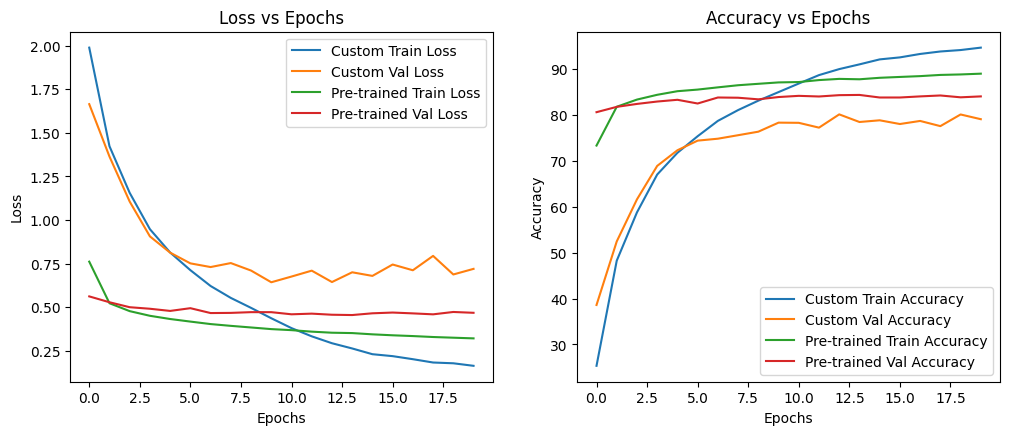

In [ ]:

# Graficar resultados
plt.figure(figsize=(12, 10))

# Gráficas de pérdida
plt.subplot(2, 2, 1)
plt.plot(custom_train_losses, label='Custom Train Loss')
plt.plot(custom_val_losses, label='Custom Val Loss')
plt.plot(pretrained_train_losses, label='Pre-trained Train Loss')
plt.plot(pretrained_val_losses, label='Pre-trained Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

# Gráficas de precisión
plt.subplot(2, 2, 2)
plt.plot(custom_train_accs, label='Custom Train Accuracy')
plt.plot(custom_val_accs, label='Custom Val Accuracy')
plt.plot(pretrained_train_accs, label='Pre-trained Train Accuracy')
plt.plot(pretrained_val_accs, label='Pre-trained Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

plt.show()